ベイズ最適化の問題として手法の比較などを行う

In [25]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import ngboost as ngb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import math
import os
import time
from scipy.stats import norm

In [4]:
#　ファイルの読み込み
data = pd.read_csv('../data/original/train.csv')
target_data = pd.read_csv('../data/original/test.csv')

data.drop(data.select_dtypes(['object']), axis=1, inplace=True)
data.drop('Id', axis=1, inplace=True)
data.replace('NaN', np.nan, inplace=True)
data.dropna(inplace=True)
data = pd.DataFrame(MinMaxScaler().fit_transform(data), columns=data.columns)
# data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,...,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,0.212625,0.170087,0.041239,0.526539,0.508729,0.709730,0.594722,0.067805,0.077675,0.030251,...,0.108063,0.084333,0.039574,0.006592,0.033543,0.004529,0.009372,0.485443,0.448930,0.208695
std,0.245722,0.083106,0.037997,0.172603,0.152605,0.238213,0.350433,0.118438,0.082988,0.107075,...,0.142204,0.117715,0.111018,0.058607,0.120420,0.062071,0.066304,0.244350,0.333761,0.115326
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.133562,0.029400,0.375000,0.428571,0.561538,0.266667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000,0.132959
50%,0.176471,0.167808,0.037935,0.500000,0.428571,0.723077,0.750000,0.000000,0.066265,0.000000,...,0.000000,0.049360,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000,0.180062
75%,0.294118,0.202055,0.047026,0.625000,0.571429,0.946154,0.916667,0.106250,0.124380,0.000000,...,0.196033,0.124314,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000,0.255929
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# グローバル変数の定義
obj_column = 'SalePrice'
x_data = data.drop(obj_column, axis=1)
y_data = data[obj_column]

In [6]:
# 勾配ブ―スティング
def xgb_build(x_train, x_test, y_train, y_test):
    s_time = time.time()
    # XGBoostモデルの定義
    model = GradientBoostingRegressor()
    # XGBoostモデルをトレーニングデータ全体で再学習
    model.fit(x_train, y_train)
    # テストデータでの評価
    y_pred = model.predict(x_test)
    test_score = r2_score(y_test, y_pred)
    return {'mu': y_pred, 'std': None}, test_score, time.time()-s_time

In [7]:
def gpr_build(x_train, x_test, y_train, y_test):
    s_time = time.time()
    # ガウス過程回帰の定義
    kernel = ConstantKernel()*RBF(length_scale=1)+WhiteKernel()
    model = GaussianProcessRegressor(kernel=kernel, random_state=0)
    # ガウス過程回帰のモデルをトレーニングデータ全体で再学習
    model.fit(x_train, y_train)
    # テストデータを用いた評価
    y_pred, sigma = model.predict(x_test, return_std=True)
    test_score = r2_score(y_test, y_pred)
    return {'mu': y_pred, 'std': sigma}, test_score, time.time()-s_time

In [14]:
# 自然勾配ブ―スティング
def ngb_build(x_train, x_test, y_train, y_test):
    s_time = time.time()
    # XGBoostモデルの定義
    model = ngb.NGBRegressor(n_estimators=200)
    # XGBoostモデルをトレーニングデータ全体で再学習
    model.fit(x_train, y_train)
    # テストデータを用いた評価
    y_pred = model.pred_dist(x_test)
    y_pred_mu = y_pred.params['loc']
    y_pred_std = y_pred.params['scale']
    test_score = r2_score(y_test, y_pred_mu)
    return {'mu': y_pred_mu, 'std': y_pred_std}, test_score, time.time()-s_time

In [9]:
# テストデータの割合を変えながら学習を行う。決定係数と計算時間をcsvファイルで出力する。
def runs(data, algo, filename):
    scores = []
    times = []
    for random_state in range(11):
        tmp_score = []
        tmp_time = []
        for test_size in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
            model, score, time = algo(x_train, x_test, y_train, y_test)
            print(test_size, random_state, score, time)
            tmp_score.append(score)
            tmp_time.append(time)
        scores.append(tmp_score)
        times.append(tmp_time)

    # 結果をDataFrameに変換し、CSVファイルに出力
    scores = pd.DataFrame(scores)
    scores.to_csv('score_'+filename, index=False, header=False)
    times = pd.DataFrame(times)
    times.to_csv('time_'+filename, index=False, header=False)

In [10]:
# runs(data, xgb_build, 'xgb.csv')
# runs(data, gpr_build, 'gpr.csv')
# runs(data, ngb_build, 'ngb.csv')

In [47]:
# 確率的回帰モデルの尤度を計算する。
def likelihood_ana(data, algo):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0)
    pred, score, time = algo(x_train, x_test, y_train, y_test)
    likelihoods = norm.pdf(y_test, loc=pred['mu'], scale=pred['std'])/100
    print(np.prod(np.log(likelihoods)), score, time)
    return likelihoods, pred
    # mean_log_likelihood = np.mean(likelihoods)
    # print(mean_log_likelihood, score, time)

-2.7876723303200645e+178 0.3750967006406982 2.5793652534484863
[iter 0] loss=-0.6991 val_loss=0.0000 scale=1.0000 norm=0.5817
[iter 100] loss=-1.5366 val_loss=0.0000 scale=2.0000 norm=0.7934
-1.5600824297344397e+182 0.741297249859705 5.651700735092163


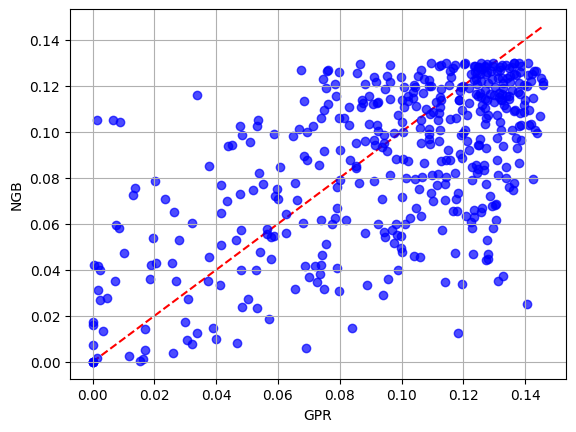

In [64]:
gpr_like, gpr_pred = likelihood_ana(data, gpr_build)
ngb_like, ngb_pred = likelihood_ana(data, ngb_build)

minlim = min(gpr_like.min(), ngb_like.min())
maxlim = max(gpr_like.max(), ngb_like.max())

plt.plot([minlim, maxlim], [minlim, maxlim], color='red', linestyle='--', zorder=1)
plt.scatter(gpr_like, ngb_like, marker='o', color='blue', alpha=0.7)
plt.xlabel('GPR')
plt.ylabel('NGB')
plt.grid(True)
plt.savefig('./r2/likelihood.jpg', format='jpeg')
plt.show()

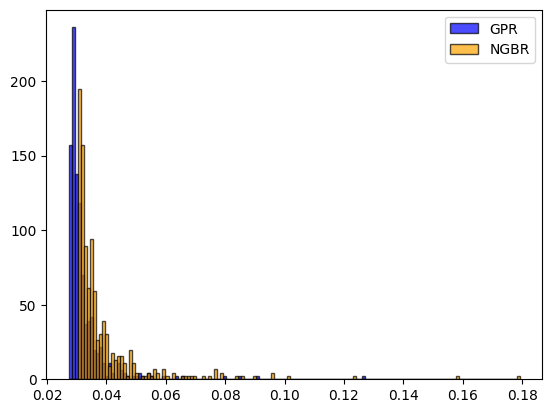

In [65]:
# ヒストグラムをプロット
bins = np.linspace(min(min(gpr_pred['std']), min(ngb_pred['std'])), max(max(gpr_pred['std']), max(ngb_pred['std'])), 150)
plt.hist(gpr_pred['std'], bins=bins, alpha=0.7, label='GPR', color='blue', edgecolor='black', density=True)
plt.hist(ngb_pred['std'], bins=bins, alpha=0.7, label='NGBR', color='orange', edgecolor='black', density=True)
plt.legend()
plt.savefig('./r2/sigma_hist.jpg', format='jpeg')
plt.show()